In [12]:
import cv2
import numpy as np
from tqdm import tqdm
import h5py as h5py
import pandas as pd

In [13]:
df = pd.read_csv('input/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [14]:
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

In [15]:
width = 299
X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread('input/train/%s.jpg' % df['id'][i]), (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1

100%|██████████| 10222/10222 [00:41<00:00, 246.21it/s]


### Visualization

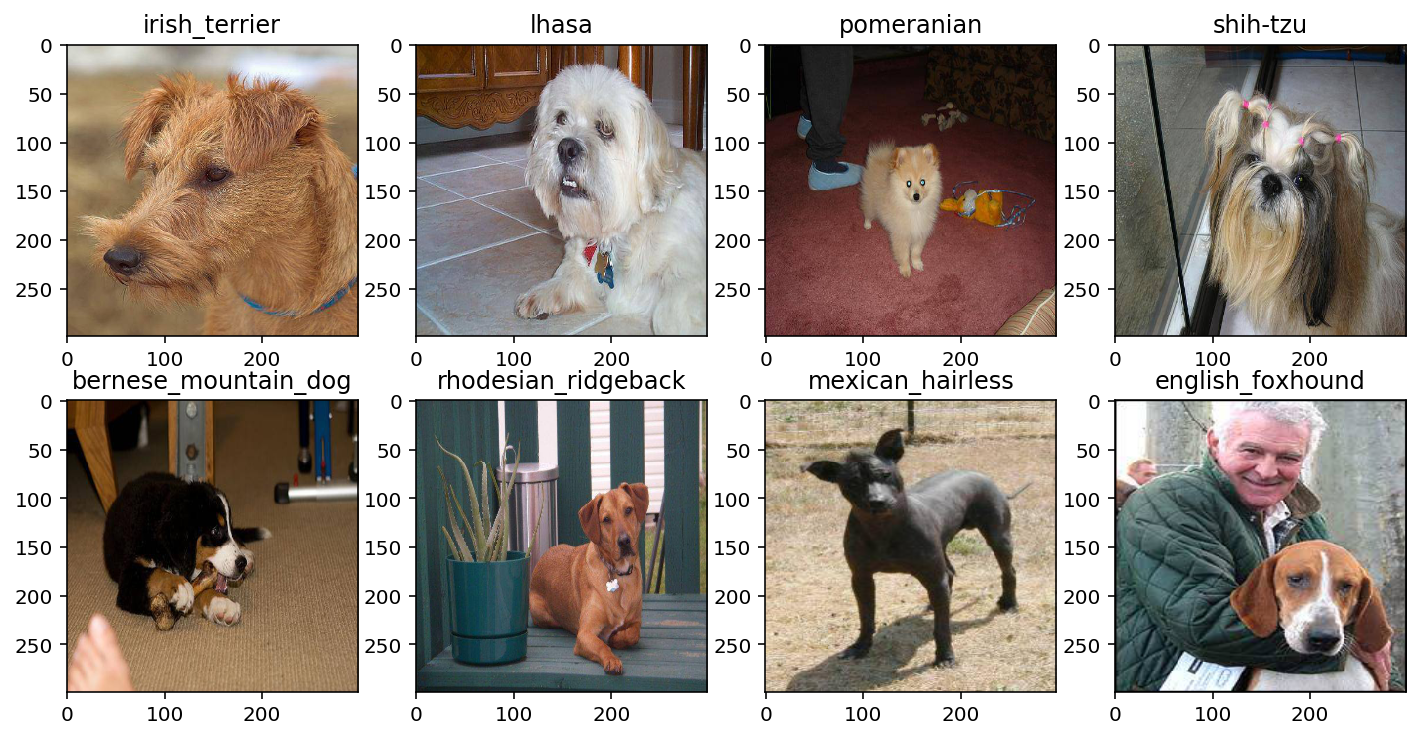

In [16]:
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(num_to_class[y[random_index].argmax()])

### Feature Engineering 

In [17]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

In [18]:
def get_features(MODEL, data=X):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [21]:
X_sample = X[:100]

In [23]:
inception_features = get_features(InceptionV3, X_sample)
xception_features = get_features(Xception, X_sample)
features = np.concatenate([inception_features, xception_features], axis=-1)

100/100 [==============================] - 108s 1s/step


In [25]:
features.shape

(100, 4096)

In [26]:
inception_features.shape

(100, 2048)

In [28]:
y_sample = y[:100]

### Training 

In [30]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(features, y_sample, batch_size=128, epochs=10, validation_split=0.1)

Train on 90 samples, validate on 10 samples
Epoch 1/10
90/90 [==============================] - 2s 21ms/step - loss: 5.0502 - acc: 0.0000e+00 - val_loss: 4.9056 - val_acc: 0.0000e+00
Epoch 2/10
90/90 [==============================] - 0s 268us/step - loss: 4.3327 - acc: 0.0556 - val_loss: 4.9011 - val_acc: 0.1000
Epoch 3/10
90/90 [==============================] - 0s 297us/step - loss: 3.8426 - acc: 0.1667 - val_loss: 4.9976 - val_acc: 0.1000
Epoch 4/10
90/90 [==============================] - 0s 341us/step - loss: 3.4284 - acc: 0.1667 - val_loss: 5.1057 - val_acc: 0.1000
Epoch 5/10
90/90 [==============================] - 0s 392us/step - loss: 2.9285 - acc: 0.3667 - val_loss: 5.1821 - val_acc: 0.1000
Epoch 6/10
90/90 [==============================] - 0s 428us/step - loss: 2.7465 - acc: 0.3111 - val_loss: 5.2124 - val_acc: 0.1000
Epoch 7/10
90/90 [==============================] - 0s 468us/step - loss: 2.3767 - acc: 0.5556 - val_loss: 5.1984 - val_acc: 0.1000
Epoch 8/10
90/90 [=======

In [40]:
features.shape

(100, 4096)

In [41]:
y_sample.shape

(100, 120)

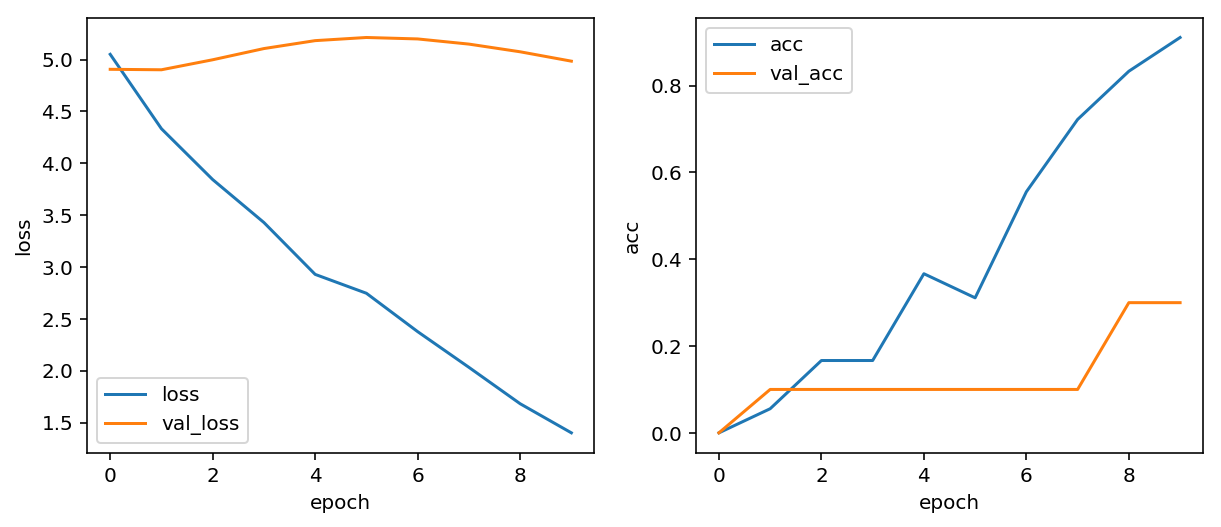

In [38]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

### Test 